In [3]:
from jitcdde import t
from parameters import *
# from parameters_h_overall import *
from msrDynamics import Node, System
import pandas as pd

In [4]:
# plotting style 
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "monospace"

# Set a professional color scheme
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 
          'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

tls = 22
# Function to update the style of each axis
def update_axis_style(ax, title = '', x_label='', y_label='', x_ticks=True, y_scale='linear'):
    ax.set_title(title,fontsize=tls)
    ax.set_xlabel(x_label,fontsize=tls)
    ax.set_ylabel(y_label,fontsize=tls)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.tick_params(axis='x', which='both', bottom=x_ticks, top=False, labelbottom=x_ticks,labelsize=tls)
    ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=True,labelsize=tls)
    ax.set_yscale(y_scale)

lw = 3

In [5]:
# unpack data and align insertion

# unpack ORNL data 
df_power_reversed = pd.read_csv("./data/insertion.csv",header=None)
df_inlet_reversed = pd.read_csv("./data/fuel_inlet_temp.csv",header=None)
df_outlet_reversed = pd.read_csv("./data/fuel_outlet_temp.csv",header=None)
df_power = df_power_reversed.iloc[::-1] 
df_inlet = df_inlet_reversed.iloc[::-1]
df_outlet = df_outlet_reversed.iloc[::-1]
df_power = df_power.reset_index(drop=True)
df_inlet = df_inlet.reset_index(drop=True)
df_outlet = df_outlet.reset_index(drop=True)
df_inlet[1] = [F_to_K(t) for t in df_inlet[1]]
df_outlet[1] = [F_to_K(t) for t in df_outlet[1]]

In [6]:
# params_hA = [2.26103880e-02, 6.35249293e-03, 5.01754655e-05, 7.79148981e-03,
#           4.50255426e-03, 1.05622729e-02, 1.26345367e-03, 6.71738834e-03,
#           1.02512617e-01, 2.30353891e-03, 7.33258046e-03]

params_hA = [0.01117443, 0.01157201, 0.00073944, 0.00819707, 0.00347761, 
          0.00782532, 0.00232722, 0.00598841, 0.07557605, 0.001842,   
          0.00898831]

# params_fb = [-3.51e-05, -2.98e-05, 6.81e-06] # openmc
# params_fb = [-6.08617335e-05,  1.4e-05,  2.25540322e-05] # estimation

params_fb = [-6.10e-05,  4.99e-05,  3.00e-05] # new time adjusted estimate 

hA_ft_c, hA_tc_c, hA_mc_c, hA_ft_hx, hA_ht_hx, hA_ct_hx, hA_th_hxch, \
hA_ht_hxhw, hA_tw_hxhw, hA_ht_hxhwc, hA_tw_hxhwc = params_hA

a_f, a_b, a_c = params_fb

P = 2.2

Instantiate System Object & Nodes

In [7]:
# ARE system        
ARE = System()

# CORE NODES
c_f1 = Node(m = m_f_c/2, scp = scp_f, W = W_f, y0 = T0_c_f1)
c_f2 = Node(m = m_f_c/2, scp = scp_f, W = W_f, y0 = T0_c_f2)
c_t1 = Node(m = m_t, scp = scp_t, y0 = T0_c_t1)
c_c1 = Node(m = m_c_c/2, scp = scp_c, W = W_c, y0 = T0_c_c1)
c_c2 = Node(m = m_c_c/2, scp = scp_c, W = W_c, y0 = T0_c_c2) 
c_m1 = Node(m = m_m_c, scp = scp_m, y0 = T0_c_m + 1000)
n = Node(y0 = n_frac0)
C1 = Node(y0 = C0[0])
C2 = Node(y0 = C0[1])
C3 = Node(y0 = C0[2])
C4 = Node(y0 = C0[3])
C5 = Node(y0 = C0[4])
C6 = Node(y0 = C0[5])
rho = Node(y0 = 0.00)

# add reactivity input
inserted = 400e-5
def rho_insert(t):
    if (t<t_ins):
        return 0.0
    elif (t<(t_ins+insert_duration)):
        return ((t-t_ins))*(inserted/insert_duration) # linear
    elif (t < t_wd):
        return inserted
    elif (t < t_wd+insert_duration):
        return inserted-((t-t_wd))*(inserted/insert_duration) # linear
    else:
        return 0.0

rho_ext = ARE.add_input(rho_insert, T)

# FUEL-HELIUM HX1
hx_fh1_f1 = Node(m = m_f_hx/2, scp = scp_f, W = W_f/2, y0 = T0_hfh_f1)
hx_fh1_f2 = Node(m = m_f_hx/2, scp = scp_f, W = W_f/2, y0 = T0_hfh_f2)
hx_fh1_t1 = Node(m = m_t_hxfh, scp = scp_t, y0 = T0_hfh_t1)
hx_fh1_h1 = Node(m = m_h_hxfh/2, scp = scp_h, W = W_h_fh, y0 = T0_hfh_h1)
hx_fh1_h2 = Node(m = m_h_hxfh/2, scp = scp_h, W = W_h_fh, y0 = T0_hfh_h2)

# FUEL-HELIUM HX2
hx_fh2_f1 = Node(m = m_f_hx/2, scp = scp_f, W = W_f/2, y0 = T0_hfh_f1)
hx_fh2_f2 = Node(m = m_f_hx/2, scp = scp_f, W = W_f/2, y0 = T0_hfh_f2)
hx_fh2_t1 = Node(m = m_t_hxfh, scp = scp_t, y0 = T0_hfh_t1)
hx_fh2_h1 = Node(m = m_h_hxfh/2, scp = scp_h, W = W_h_fh, y0 = T0_hfh_h1)
hx_fh2_h2 = Node(m = m_h_hxfh/2, scp = scp_h, W = W_h_fh, y0 = T0_hfh_h2)

# COOLANT-HELIUM HX1
hx_ch1_c1 = Node(m = m_c_hx/2, scp = scp_c, W = W_c/2, y0 = T0_hch_c1)
hx_ch1_c2 = Node(m = m_c_hx/2, scp = scp_c, W = W_c/2, y0 = T0_hch_c2)
hx_ch1_t1 = Node(m = m_t_hxch, scp = scp_t, y0 = T0_hch_t1)
hx_ch1_h1 = Node(m = m_h_hxch/2, scp = scp_h, W = W_h_ch, y0 = T0_hch_h1)
hx_ch1_h2 = Node(m = m_h_hxch/2, scp = scp_h, W = W_h_ch, y0 = T0_hch_h2)

# COOLANT-HELIUM HX2
hx_ch2_c1 = Node(m = m_c_hx/2, scp = scp_c, W = W_c/2, y0 = T0_hch_c1)
hx_ch2_c2 = Node(m = m_c_hx/2, scp = scp_c, W = W_c/2, y0 = T0_hch_c2)
hx_ch2_t1 = Node(m = m_t_hxch, scp = scp_t, y0 = T0_hfh_t1)
hx_ch2_h1 = Node(m = m_h_hxch/2, scp = scp_h, W = W_h_ch, y0 = T0_hch_h1)
hx_ch2_h2 = Node(m = m_h_hxch/2, scp = scp_h, W = W_h_ch, y0 = T0_hch_h2)

# HELIUM-WATER HX1 (FUEL LOOP)
hx_hwf1_h1 = Node(m = m_h_hxhwf/2, scp = scp_h, W = W_h_fh, y0 = T0_hhwf_h1)
hx_hwf1_h2 = Node(m = m_h_hxhwf/2, scp = scp_h, W = W_h_fh, y0 = T0_hhwf_h2)
hx_hwf1_t1 = Node(m = m_t_hxhwf, scp = scp_t, y0 = T0_hhwf_t1)
hx_hwf1_w1 = Node(m = m_w_hxhwf/2, scp = scp_w, W = W_hhwf_w, y0 = T0_hhwf_w1)
hx_hwf1_w2 = Node(m = m_w_hxhwf/2, scp = scp_w, W = W_hhwf_w, y0 = T0_hhwf_w2)

# HELIUM-WATER HX2 (FUEL LOOP)
hx_hwf2_h1 = Node(m = m_h_hxhwf/2, scp = scp_h, W = W_h_fh, y0 = T0_hhwf_h1)
hx_hwf2_h2 = Node(m = m_h_hxhwf/2, scp = scp_h, W = W_h_fh, y0 = T0_hhwf_h2)
hx_hwf2_t1 = Node(m = m_t_hxhwf, scp = scp_t, y0 = T0_hhwf_t1)
hx_hwf2_w1 = Node(m = m_w_hxhwf/2, scp = scp_w, W = W_hhwf_w, y0 = T0_hhwf_w1)
hx_hwf2_w2 = Node(m = m_w_hxhwf/2, scp = scp_w, W = W_hhwf_w, y0 = T0_hhwf_w2)

# HELIUM-WATER HX1 (COOLANT LOOP)
hx_hwc1_h1 = Node(m = m_h_hxhwc/2, scp = scp_h, W = W_h_ch, y0 = T0_hhwc_h1)
hx_hwc1_h2 = Node(m = m_h_hxhwc/2, scp = scp_h, W = W_h_ch, y0 = T0_hhwc_h2)
hx_hwc1_t1 = Node(m = m_t_hxhwc, scp = scp_t, y0 = T0_hhwf_t1)
hx_hwc1_w1 = Node(m = m_w_hxhwc/2, scp = scp_w, W = W_hhwc_w, y0 = T0_hhwc_w1)
hx_hwc1_w2 = Node(m = m_w_hxhwc/2, scp = scp_w, W = W_hhwc_w, y0 = T0_hhwc_w2)

# HELIUM-WATER HX2 (COOLANT LOOP)
hx_hwc2_h1 = Node(m = m_h_hxhwc/2, scp = scp_h, W = W_h_ch, y0 = T0_hhwc_h1)
hx_hwc2_h2 = Node(m = m_h_hxhwc/2, scp = scp_h, W = W_h_ch, y0 = T0_hhwc_h2)
hx_hwc2_t1 = Node(m = m_t_hxhwc, scp = scp_t, y0 = T0_hhwf_t1)
hx_hwc2_w1 = Node(m = m_w_hxhwc/2, scp = scp_w, W = W_hhwc_w, y0 = T0_hhwc_w1)
hx_hwc2_w2 = Node(m = m_w_hxhwc/2, scp = scp_w, W = W_hhwc_w, y0 = T0_hhwc_w2)



In [8]:


ARE.add_nodes([c_f1,c_f2,c_t1,c_c1,c_c2,c_m1,n,C1,C2,C3,C4,C5,C6,rho,
              hx_fh1_f1,hx_fh1_f2,hx_fh1_t1,hx_fh1_h1,hx_fh1_h2,
              hx_fh2_f1,hx_fh2_f2,hx_fh2_t1,hx_fh2_h1,hx_fh2_h2,
              hx_ch1_c1,hx_ch1_c2,hx_ch1_t1,hx_ch1_h1,hx_ch1_h2,
              hx_ch2_c1,hx_ch2_c2,hx_ch2_t1,hx_ch2_h1,hx_ch2_h2,
              hx_hwf1_h1,hx_hwf1_h2,hx_hwf1_t1,hx_hwf1_w1,hx_hwf1_w2,
              hx_hwf2_h1,hx_hwf2_h2,hx_hwf2_t1,hx_hwf2_w1,hx_hwf2_w2,
              hx_hwc1_h1,hx_hwc1_h2,hx_hwc1_t1,hx_hwc1_w1,hx_hwc1_w2,
              hx_hwc2_h1,hx_hwc2_h2,hx_hwc2_t1,hx_hwc2_w1,hx_hwc2_w2,
              ])

Define Dynamics

In [9]:
mann = False

# CORE
c_f1.set_dTdt_advective(source = (hx_fh1_f2.y(t-tau_hx_c_f)+hx_fh2_f2.y(t-tau_hx_c_f))/2) 
c_f1.set_dTdt_internal(source = [n.y()], k = [k_f1*P])
c_f1.set_dTdt_convective(source = [c_t1.y()], hA = [hA_ft_c/2])

c_f2.set_dTdt_advective(source = c_f1.y()) 
c_f2.set_dTdt_internal(source = [n.y()], k = [k_f2*P])
if mann:
    c_f2.dTdt_convective = c_f1.dTdt_convective
    c_t1.set_dTdt_convective(source = [c_f1.y() ,c_f1.y(), c_c1.y(), c_c1.y()], hA = [hA_ft_c/2,hA_ft_c/2,hA_tc_c/2,hA_tc_c/2]) 
else:
    c_f2.set_dTdt_convective(source = [c_t1.y()], hA = [hA_ft_c/2])
    c_t1.set_dTdt_convective(source = [c_f1.y() ,c_f2.y(), c_c1.y(), c_c2.y()], hA = [hA_ft_c/2,hA_ft_c/2,hA_tc_c/2,hA_tc_c/2])


c_c1.set_dTdt_advective(source = (hx_ch1_c2.y(t-tau_c_hx_f)+hx_ch2_c2.y(t-tau_c_hx_f))/2)
c_c1.set_dTdt_convective(source = [c_t1.y(),c_m1.y()], hA = [hA_tc_c/2,hA_mc_c/2])

c_c2.set_dTdt_advective(source = c_c1.y())
if mann:
    c_c2.dTdt_convective = c_c1.dTdt_convective
else:
    c_c2.set_dTdt_convective(source = [c_t1.y(),c_m1.y()], hA = [hA_tc_c/2,hA_mc_c/2])

c_m1.set_dTdt_internal(source = [n.y()], k = [k_m*P])
c_m1.set_dTdt_convective(source = [c_c1.y(),c_c2.y()], hA = [hA_mc_c/2]*2)

n.set_dndt(rho.y()+rho_ext, beta_t, Lam, lam, [C1.y(), C2.y(), C3.y(), C4.y(), C5.y(), C6.y()])
C1.set_dcdt(n.y(), beta[0], Lam, lam[0], tau_c, tau_l)
C2.set_dcdt(n.y(), beta[1], Lam, lam[1], tau_c, tau_l)
C3.set_dcdt(n.y(), beta[2], Lam, lam[2], tau_c, tau_l)
C4.set_dcdt(n.y(), beta[3], Lam, lam[3], tau_c, tau_l)
C5.set_dcdt(n.y(), beta[4], Lam, lam[4], tau_c, tau_l)
C6.set_dcdt(n.y(), beta[5], Lam, lam[5], tau_c, tau_l)
rho.set_drdt([c_f1.dydt,c_f2.dydt,c_m1.dydt,c_c1.dydt,c_c2.dydt],[a_f/2,a_f/2,a_b,a_c/2,a_c/2])

# FUEL-HELIUM HX1
hx_fh1_f1.set_dTdt_advective(source = c_f2.y(t-tau_c_hx_f))
hx_fh1_f1.set_dTdt_convective(source = [hx_fh1_t1.y()], hA = [hA_ft_hx/2])

hx_fh1_f2.set_dTdt_advective(source = hx_fh1_f1.y())
if mann:
    hx_fh1_f2.dTdt_convective = hx_fh1_f1.dTdt_convective
    hx_fh1_t1.set_dTdt_convective(source = [hx_fh1_f1.y(),hx_fh1_f1.y(),hx_fh1_h1.y(),hx_fh1_h1.y()],
                              hA = [hA_ft_hx/2,hA_ft_hx/2,hA_ht_hx/2,hA_ht_hx/2])
else:
    hx_fh1_f2.set_dTdt_convective(source = [hx_fh1_t1.y()], hA = [hA_ft_hx/2])
    hx_fh1_t1.set_dTdt_convective(source = [hx_fh1_f1.y(),hx_fh1_f2.y(),hx_fh1_h1.y(),hx_fh1_h2.y()],
                              hA = [hA_ft_hx/2,hA_ft_hx/2,hA_ht_hx/2,hA_ht_hx/2])

hx_fh1_h1.set_dTdt_advective(source = hx_hwf2_h2.y(t-tau_h))
hx_fh1_h1.set_dTdt_convective(source = [hx_fh1_t1.y()], hA = [hA_ht_hx/2])

hx_fh1_h2.set_dTdt_advective(source = hx_fh1_h1.y())
if mann:
    hx_fh1_h2.dTdt_convective = hx_fh1_h1.dTdt_convective
else:
    hx_fh1_h2.set_dTdt_convective(source = [hx_fh1_t1.y()], hA = [hA_ht_hx/2])

# FUEL-HELIUM HX2
hx_fh2_f1.set_dTdt_advective(source = c_f2.y(t-tau_c_hx_f))
hx_fh2_f1.set_dTdt_convective(source = [hx_fh2_t1.y()], hA = [hA_ft_hx/2])

hx_fh2_f2.set_dTdt_advective(source = hx_fh2_f1.y())
if mann:
    hx_fh2_f2.dTdt_convective = hx_fh2_f1.dTdt_convective
    hx_fh2_t1.set_dTdt_convective(source = [hx_fh2_f1.y(),hx_fh2_f1.y(),hx_fh2_h1.y(),hx_fh2_h1.y()],
                                hA = [hA_ft_hx/2,hA_ft_hx/2,hA_ht_hx/2,hA_ht_hx/2])
else:
    hx_fh2_f2.set_dTdt_convective(source = [hx_fh2_t1.y()], hA = [hA_ft_hx/2])
    hx_fh2_t1.set_dTdt_convective(source = [hx_fh2_f1.y(),hx_fh2_f2.y(),hx_fh2_h1.y(),hx_fh2_h2.y()],
                                  hA = [hA_ft_hx/2,hA_ft_hx/2,hA_ht_hx/2,hA_ht_hx/2])


hx_fh2_h1.set_dTdt_advective(source = hx_hwf1_h2.y())
hx_fh2_h1.set_dTdt_convective(source = [hx_fh2_t1.y()], hA = [hA_ht_hx/2])

hx_fh2_h2.set_dTdt_advective(source = hx_fh2_h1.y())
if mann:
    hx_fh2_h2.dTdt_convective = hx_fh2_h1.dTdt_convective
else:
    hx_fh2_h2.set_dTdt_convective(source = [hx_fh2_t1.y()], hA = [hA_ht_hx/2])

# COOLANT-HELIUM HX1
hx_ch1_c1.set_dTdt_advective(source = c_c2.y(t-tau_c_hx_f))
hx_ch1_c1.set_dTdt_convective(source = [hx_ch1_t1.y()], hA = [hA_ct_hx/2])

hx_ch1_c2.set_dTdt_advective(source = hx_ch1_c1.y())
if mann:
    hx_ch1_c2.dTdt_convective = hx_ch1_c1.dTdt_convective
    hx_ch1_t1.set_dTdt_convective(source = [hx_ch1_c1.y(),hx_ch1_c1.y(),hx_ch1_h1.y(),hx_ch1_h1.y()],
                                hA = [hA_ct_hx/2,hA_ct_hx/2,hA_th_hxch/2,hA_th_hxch/2])
else:
    hx_ch1_c2.set_dTdt_convective(source = [hx_ch1_t1.y()], hA = [hA_ct_hx/2])
    hx_ch1_t1.set_dTdt_convective(source = [hx_ch1_c1.y(),hx_ch1_c2.y(),hx_ch1_h1.y(),hx_ch1_h2.y()],
                                hA = [hA_ct_hx/2,hA_ct_hx/2,hA_th_hxch/2,hA_th_hxch/2])


hx_ch1_h1.set_dTdt_advective(source = hx_hwc1_h2.y(t-tau_h))
hx_ch1_h1.set_dTdt_convective(source = [hx_ch1_t1.y()], hA = [hA_th_hxch/2])

hx_ch1_h2.set_dTdt_advective(source = hx_ch1_h1.y())
if mann:
    hx_ch1_h2.dTdt_convective = hx_ch1_h1.dTdt_convective
else:
    hx_ch1_h2.set_dTdt_convective(source = [hx_ch1_t1.y()], hA = [hA_th_hxch/2])

# COOLANT-HELIUM HX2
hx_ch2_c1.set_dTdt_advective(source = c_c2.y(t-tau_c_hx_f))
hx_ch2_c1.set_dTdt_convective(source = [hx_ch2_t1.y()], hA = [hA_ct_hx/2])

hx_ch2_c2.set_dTdt_advective(source = hx_ch2_c1.y())
if mann:
    hx_ch2_c2.dTdt_convective = hx_ch2_c1.dTdt_convective
    hx_ch2_t1.set_dTdt_convective(source = [hx_ch2_c1.y(),hx_ch2_c1.y(),hx_ch2_h1.y(),hx_ch2_h1.y()],
                              hA = [hA_ct_hx/2,hA_ct_hx/2,hA_th_hxch/2,hA_th_hxch/2])
else:
    hx_ch2_c2.set_dTdt_convective(source = [hx_ch2_t1.y()], hA = [hA_ct_hx/2])
    hx_ch2_t1.set_dTdt_convective(source = [hx_ch2_c1.y(),hx_ch2_c2.y(),hx_ch2_h1.y(),hx_ch2_h2.y()],
                                hA = [hA_ct_hx/2,hA_ct_hx/2,hA_th_hxch/2,hA_th_hxch/2])


hx_ch2_h1.set_dTdt_advective(source = hx_hwc2_h2.y(t-tau_h))
hx_ch2_h1.set_dTdt_convective(source = [hx_ch2_t1.y()], hA = [hA_th_hxch/2])

hx_ch2_h2.set_dTdt_advective(source = hx_ch2_h1.y())
if mann:
    hx_ch2_h2.dTdt_convective = hx_ch2_h1.dTdt_convective
else:
    hx_ch2_h2.set_dTdt_convective(source = [hx_ch2_t1.y()], hA = [hA_th_hxch/2])

# HELIUM-WATER HX1 (FUEL LOOP)
hx_hwf1_h1.set_dTdt_advective(source = hx_fh1_h2.y())
hx_hwf1_h1.set_dTdt_convective(source = [hx_hwf1_t1.y()], hA = [hA_ht_hxhw/2])

hx_hwf1_h2.set_dTdt_advective(source = hx_hwf1_h1.y())
if mann:
    hx_hwf1_h2.dTdt_convective = hx_hwf1_h1.dTdt_convective
    hx_hwf1_t1.set_dTdt_convective(source = [hx_hwf1_h1.y(),hx_hwf1_h1.y(),hx_hwf1_w1.y(),hx_hwf1_w1.y()],
                               hA = [hA_ht_hxhw/2,hA_ht_hxhw/2,hA_tw_hxhw/2,hA_tw_hxhw/2])
else:
    hx_hwf1_h2.set_dTdt_convective(source = [hx_hwf1_t1.y()], hA = [hA_ht_hxhw/2])
    hx_hwf1_t1.set_dTdt_convective(source = [hx_hwf1_h1.y(),hx_hwf1_h2.y(),hx_hwf1_w1.y(),hx_hwf1_w2.y()],
                                hA = [hA_ht_hxhw/2,hA_ht_hxhw/2,hA_tw_hxhw/2,hA_tw_hxhw/2])


hx_hwf1_w1.set_dTdt_advective(source = T0_hhwf_w1)
hx_hwf1_w1.set_dTdt_convective(source = [hx_hwf1_t1.y()], hA = [hA_tw_hxhw/2])

hx_hwf1_w2.set_dTdt_advective(source = hx_hwf1_w1.y())
if mann:
    hx_hwf1_w2.dTdt_convective = hx_hwf1_w1.dTdt_convective
else:
    hx_hwf1_w2.set_dTdt_convective(source = [hx_hwf1_t1.y()], hA = [hA_tw_hxhw/2])

# HELIUM-WATER HX2 (FUEL LOOP)
hx_hwf2_h1.set_dTdt_advective(source = hx_fh2_h2.y())
hx_hwf2_h1.set_dTdt_convective(source = [hx_hwf2_t1.y()], hA = [hA_ht_hxhw/2])

hx_hwf2_h2.set_dTdt_advective(source = hx_hwf2_h1.y())
if mann:
    hx_hwf2_h2.dTdt_convective = hx_hwf2_h1.dTdt_convective
    hx_hwf2_t1.set_dTdt_convective(source = [hx_hwf2_h1.y(),hx_hwf2_h1.y(),hx_hwf2_w1.y(),hx_hwf2_w1.y()],
                               hA = [hA_ht_hxhw/2,hA_ht_hxhw/2,hA_tw_hxhw/2,hA_tw_hxhw/2])
else:
    hx_hwf2_h2.set_dTdt_convective(source = [hx_hwf2_t1.y()], hA = [hA_ht_hxhw/2])
    hx_hwf2_t1.set_dTdt_convective(source = [hx_hwf2_h1.y(),hx_hwf2_h2.y(),hx_hwf2_w1.y(),hx_hwf2_w2.y()],
                               hA = [hA_ht_hxhw/2,hA_ht_hxhw/2,hA_tw_hxhw/2,hA_tw_hxhw/2])

hx_hwf2_w1.set_dTdt_advective(source = T0_hhwf_w1)
hx_hwf2_w1.set_dTdt_convective(source = [hx_hwf2_t1.y()], hA = [hA_tw_hxhw/2])

hx_hwf2_w2.set_dTdt_advective(source = hx_hwf2_w1.y())
if mann:
    hx_hwf2_w2.dTdt_convective = hx_hwf2_w1.dTdt_convective
else:
    hx_hwf2_w2.set_dTdt_convective(source = [hx_hwf2_t1.y()], hA = [hA_tw_hxhw/2])

# HELIUM-WATER HX1 (COOLANT LOOP)
hx_hwc1_h1.set_dTdt_advective(source = hx_ch1_h2.y())
hx_hwc1_h1.set_dTdt_convective(source = [hx_hwc1_t1.y()], hA = [hA_ht_hxhwc/2])

hx_hwc1_h2.set_dTdt_advective(source = hx_hwc1_h1.y())
if mann:
    hx_hwc1_h2.dTdt_convective = hx_hwc1_h1.dTdt_convective
    hx_hwc1_t1.set_dTdt_convective(source = [hx_hwc1_h1.y(),hx_hwc1_h1.y(),hx_hwc1_w1.y(),hx_hwc1_w1.y()],
                                hA = [hA_ht_hxhwc/2,hA_ht_hxhwc/2,hA_tw_hxhwc/2,hA_tw_hxhwc/2])
else:
    hx_hwc1_t1.set_dTdt_convective(source = [hx_hwc1_h1.y(),hx_hwc1_h2.y(),hx_hwc1_w1.y(),hx_hwc1_w2.y()],
                                hA = [hA_ht_hxhwc/2,hA_ht_hxhwc/2,hA_tw_hxhwc/2,hA_tw_hxhwc/2])
    hx_hwc1_h2.set_dTdt_convective(source = [hx_hwc1_t1.y()], hA = [hA_ht_hxhwc/2])


hx_hwc1_w1.set_dTdt_advective(source = T0_hhwc_w1)
hx_hwc1_w1.set_dTdt_convective(source = [hx_hwc1_t1.y()], hA = [hA_tw_hxhwc/2])

hx_hwc1_w2.set_dTdt_advective(source = hx_hwc1_w1.y())
if mann:
    hx_hwc1_w2.dTdt_convective = hx_hwc1_w1.dTdt_convective
else:
    hx_hwc1_w2.set_dTdt_convective(source = [hx_hwc1_t1.y()], hA = [hA_tw_hxhwc/2])

# HELIUM-WATER HX2 (COOLANT LOOP)
hx_hwc2_h1.set_dTdt_advective(source = hx_ch2_h2.y())
hx_hwc2_h1.set_dTdt_convective(source = [hx_hwc2_t1.y()], hA = [hA_ht_hxhwc/2]) 

hx_hwc2_h2.set_dTdt_advective(source = hx_hwc2_h1.y())
if mann:
    hx_hwc2_h2.dTdt_convective = hx_hwc2_h1.dTdt_convective
    hx_hwc2_t1.set_dTdt_convective(source = [hx_hwc2_h1.y(),hx_hwc2_h1.y(),hx_hwc2_w1.y(),hx_hwc2_w1.y()],
                                hA = [hA_ht_hxhwc/2,hA_ht_hxhwc/2,hA_tw_hxhwc/2,hA_tw_hxhwc/2])
else:
    hx_hwc2_t1.set_dTdt_convective(source = [hx_hwc2_h1.y(),hx_hwc2_h2.y(),hx_hwc2_w1.y(),hx_hwc2_w2.y()],
                                hA = [hA_ht_hxhwc/2,hA_ht_hxhwc/2,hA_tw_hxhwc/2,hA_tw_hxhwc/2])
    hx_hwc2_h2.set_dTdt_convective(source = [hx_hwc2_t1.y()], hA = [hA_ht_hxhwc/2])


hx_hwc2_w1.set_dTdt_advective(source = T0_hhwc_w1)
hx_hwc2_w1.set_dTdt_convective(source = [hx_hwc2_t1.y()], hA = [hA_tw_hxhwc/2])

hx_hwc2_w2.set_dTdt_advective(source = hx_hwc2_w1.y())
if mann:
    hx_hwc2_w2.dTdt_convective = hx_hwc2_w1.dTdt_convective
else:
    hx_hwc2_w2.set_dTdt_convective(source = [hx_hwc2_t1.y()], hA = [hA_tw_hxhwc/2])


In [10]:
# solve system 
sol_jit = ARE.solve(T, populate_nodes = True, max_delay = tau_l, md_step = 0.0001)
# T, sol_jit = ARE.equilibrium_search(dT = 0.01, 
#                                     max_delay = tau_l, 
#                                     populate_nodes = True, 
#                                     md_step = 0.0001, 
#                                     abs_tol_eq = 1.0e-12, 
#                                     rel_tol_eq = 5.0e-8,
#                                     show_conv_metrics = True)

finalizing integrator...
integrating...


Integration progress:   0%|          | 0/100000 [00:00<?, ?it/s]

Generating, compiling, and loading C code.


Integration progress:   5%|▍         | 4696/100000 [00:08<00:44, 2135.55it/s]/home/luke/anaconda3/envs/onion_dynamics/lib/python3.12/site-packages/jitcdde/_jitcdde.py:1644: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry (though you should think about increasing your sampling time).
  return super().integrate(target_time)[:self.input_base_n]
Integration progress: 100%|██████████| 100000/100000 [00:08<00:00, 11241.67it/s]


populating nodes objects solution vectors...


In [15]:
# get indices for simulation data
t_before_data = (1110-df_inlet[0][0])*60
duration_data = (df_inlet.iloc[-1][0]-df_inlet[0][0])*60
t_end_data = df_inlet.iloc[-1][0]
t_before_sim = t_ins-t_before_data
T_insert = np.array([t for t in T if (t > (t_before_sim)) and (t < (t_before_sim)+(duration_data))])
i_insert = [t[0] for t in enumerate(T) if (t[1] > (t_before_sim)) and (t[1] < (t_before_sim)+(duration_data))]
adj = (df_inlet[0][0])*60-T_insert[0]
df_outlet = df_outlet[:-2]

# adjust to reported initial values (graphical interpretaion correction)
dp = df_power[1][0]-2.34
df_power[1] = [p-dp for p in df_power[1]]

dt_fin = df_inlet[1][0]-F_to_K(1217)
df_inlet[1] = [tf-dt_fin for tf in df_inlet[1]]

dt_fout = df_outlet[1][0]-F_to_K(1573)
df_outlet[1] = [tf-dt_fout for tf in df_outlet[1]]

# avg temp
ornl_diff = [df_outlet[1][i]-df_inlet[1][i] for i in range(len(df_inlet))]
ornl_avg = sum(ornl_diff)/len(ornl_diff)

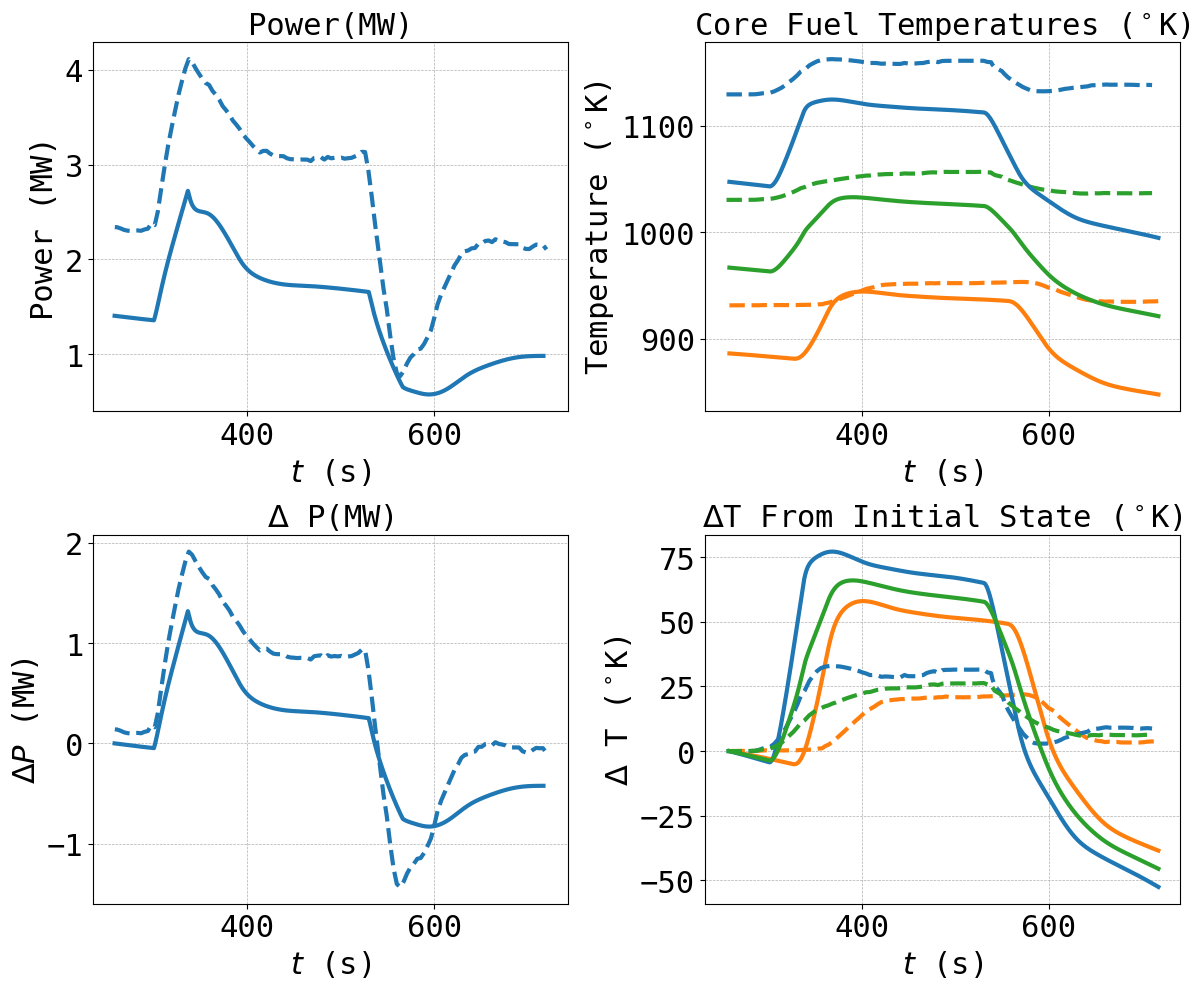

In [16]:
fig,axs = plt.subplots(2,2,figsize=(12,10))

update_axis_style(axs[0,0],"Power(MW)")
axs[0,0].plot(df_power[0]*60-adj,df_power[1],label="ORNL-1845",linestyle="--",color=colors[0],linewidth=lw)
axs[0,0].plot(T_insert,[s*P for s in n.y_out[i_insert[0]:(i_insert[-1]+1)]],label="msrDynamics",color=colors[0],linewidth=lw)
axs[0,0].set_xlabel(r"$t$ (s)")
axs[0,0].set_ylabel("Power (MW)")
# axs[0,0].legend()

ornl_avg = (df_inlet[1]+df_outlet[1])/2
jitcdde_avg = (((np.array(hx_fh1_f2.y_out)+np.array(hx_fh1_f2.y_out))/2)+(np.array(c_f2.y_out)))/2
jit_inlet = (np.array(hx_fh1_f2.y_out)+np.array(hx_fh1_f2.y_out))/2

update_axis_style(axs[0,1],r"Core Fuel Temperatures ($^\circ$K)")
axs[0,1].plot(df_inlet[0]*60-adj,df_inlet[1],label="inlet, ORNL-1845",color=colors[1],linestyle="--",linewidth=lw)
axs[0,1].plot(df_outlet[0]*60-adj,df_outlet[1],label="outlet, ORNL-1845",color=colors[0],linestyle="--",linewidth=lw)
axs[0,1].plot(df_outlet[0]*60-adj,ornl_avg,label="avg, ORNL-1845",color=colors[2],linestyle="--",linewidth=lw)
axs[0,1].plot(T_insert,jit_inlet[i_insert[0]:(i_insert[-1]+1)],label="inlet, msrDynamics",color=colors[1],linewidth=lw)
axs[0,1].plot(T_insert,c_f2.y_out[i_insert[0]:(i_insert[-1]+1)],label="outlet, msrDynamics",color=colors[0],linewidth=lw)
axs[0,1].plot(T_insert,jitcdde_avg[i_insert[0]:(i_insert[-1]+1)],label="average, msrDynamics",color=colors[2],linewidth=lw)
axs[0,1].set_xlabel(r"$t$ (s)")
axs[0,1].set_ylabel(r"Temperature ($^\circ$K)")
# axs[0,1].legend()

# delta
update_axis_style(axs[1,0],r"$\Delta$ P(MW)")
axs[1,0].plot(df_power[0]*60-adj,df_power[1]-P,label="ORNL-1845",color=colors[0],linestyle='--',linewidth=lw)
axs[1,0].plot(T_insert,[P*(s-n.y_out[i_insert[0]-1]) for s in n.y_out[i_insert]],label="msrDynamics",color=colors[0],linewidth=lw)
axs[1,0].set_xlabel(r"$t$ (s)")
axs[1,0].set_ylabel(r"$\Delta P$ (MW)")
# axs[1,0].legend()

ornl_avg = (df_inlet[1]+df_outlet[1])/2
jitcdde_avg = (((np.array(hx_fh1_f2.y_out)+np.array(hx_fh1_f2.y_out))/2)+(np.array(c_f2.y_out)))/2
jit_inlet = (np.array(hx_fh1_f2.y_out)+np.array(hx_fh1_f2.y_out))/2

update_axis_style(axs[1,1],r"$\Delta$T From Initial State ($^\circ$K)")
axs[1,1].plot(T_insert,jit_inlet[i_insert]-jit_inlet[i_insert[0]-1],label="inlet, msrDynamics",color=colors[1],linewidth=lw)
axs[1,1].plot(df_inlet[0]*60-adj,df_inlet[1]-df_inlet[1][0],linestyle ="--",label="inlet, ORNL-1845 ",color=colors[1],linewidth=lw)
axs[1,1].plot(T_insert,c_f2.y_out[i_insert]-c_f2.y_out[i_insert[0]-1],label="outlet, msrDynamics",color=colors[0],linewidth=lw)
axs[1,1].plot(df_outlet[0]*60-adj,df_outlet[1]-df_outlet[1][0],linestyle="--",label="outlet, ORNL-1845 ",color=colors[0],linewidth=lw)
axs[1,1].plot(T_insert,jitcdde_avg[i_insert]-jitcdde_avg[i_insert[0]-1],label="average, msrDynamics",color=colors[2],linewidth=lw)
axs[1,1].plot(df_outlet[0]*60-adj,ornl_avg-ornl_avg[0],label="average, ORNL-1845",color=colors[2],linestyle="--",linewidth=lw)
axs[1,1].set_xlabel(r"$t$ (s)")
axs[1,1].set_ylabel(r" $\Delta$ T ($^\circ$K)")
# axs[1,1].legend()

plt.tight_layout()

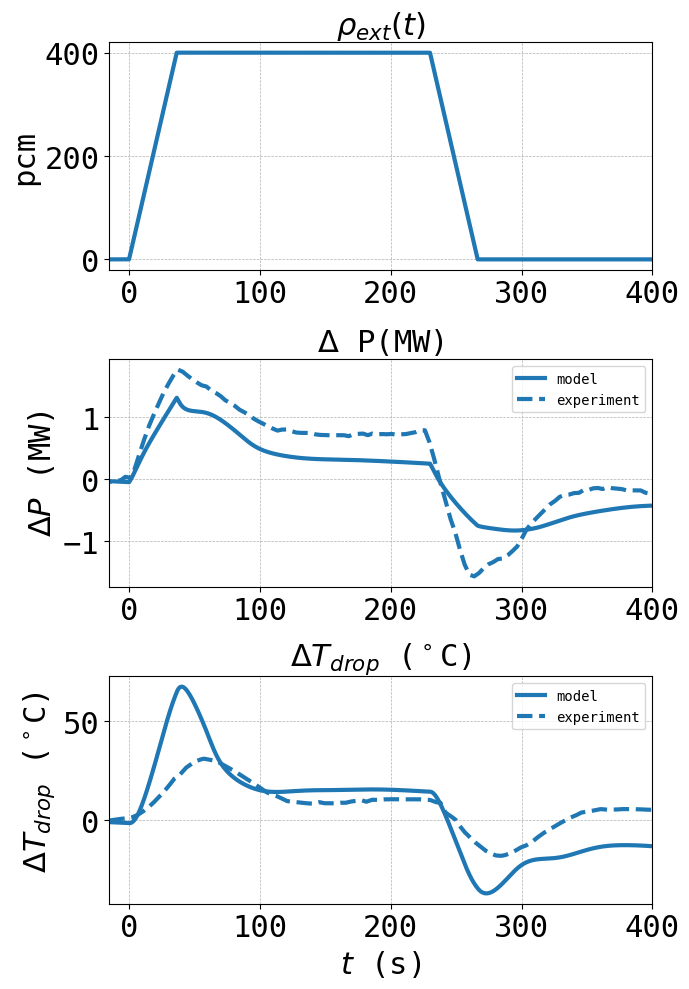

In [17]:
t0, tf = -15.0, 400.0 






from scipy.interpolate import interp1d

def rho_ext(t):
    if t <= t_ins:
        rho = 0.0
    elif t <= t_ins + insert_duration:
        rho = ((t-t_ins))*(11)
    elif t <= t_wd:
        rho = 400
    elif t <= t_wd + insert_duration:
        rho = 400 - (11)*(t-t_wd)
    else:
        rho = 0.0
    return rho*(1e-5) 

rho_dat = np.array([rho_ext(t) for t in T[T>=(300.0+t0)]])

# Create subplots with shared x-axis
fig, axs = plt.subplots(3, 1, figsize=(7,10), sharex=True)

update_axis_style(axs[0], title=r"$\rho_{ext}(t)$")
axs[0].plot(T[T>=(300.0+t0)]-300, rho_dat*(1e5), label=r'$\rho_{ext}$', linewidth=lw)
axs[0].set_xlim([t0,tf])
axs[0].set_ylabel(r"pcm")

update_axis_style(axs[1], r"$\Delta$ P(MW)")
axs[1].plot(T_insert-300, [P*(s-n.y_out[i_insert[0]-1]) for s in n.y_out[i_insert]], label="model", color=colors[0], linewidth=lw)
axs[1].plot((df_power[0]*60-adj)-300, df_power[1]-df_power[1][0], label="experiment", color=colors[0], linestyle='--', linewidth=lw)
axs[1].set_ylabel(r"$\Delta P$ (MW)")
axs[1].set_xlim([t0,tf])
axs[1].legend()

df_inlet_interp = interp1d(df_inlet[0]*60-adj, df_inlet[1])
df_outlet_interp = interp1d(df_outlet[0]*60-adj, df_outlet[1])
interp_range = T_insert<710.2269
update_axis_style(axs[2], r"$\Delta T_{drop}$ ($^\circ$C)")
axs[2].plot(T_insert-300, (c_f2.y_out[i_insert]-hx_fh1_f2.y_out[i_insert])-(c_f2.y_out[i_insert][0]-hx_fh1_f2.y_out[i_insert][0]), label="model", color=colors[0], linewidth=lw)
axs[2].plot(T_insert[interp_range]-300, (df_outlet_interp(T_insert[interp_range]) - df_inlet_interp(T_insert[interp_range])) - (df_outlet_interp(T_insert[interp_range])[0] - df_inlet_interp(T_insert[interp_range][0])), label="experiment", color=colors[0], linewidth=lw, linestyle='--')
axs[2].set_xlabel(r"$t$ (s)")
axs[2].set_ylabel(r" $\Delta T_{drop}$ ($^\circ$C)")
axs[2].set_xlim([t0,tf])
axs[2].legend()

# Only show x-axis label on the bottom plot
for ax in axs[:-1]:
    ax.set_xlabel('')

fig.tight_layout()